# 05_interpretability_tfidf_logistic_regression_lime.ipynb
## Interpretabilidade: Baseline (TF-IDF + Regressão Logística) com LIME

#Objetivo:

Analisar o comportamento do modelo baseline de classificação de fake news (TF-IDF + Regressão Logística) por meio de técnicas de interpretabilidade local, permitindo compreender quais evidências linguísticas influenciam as decisões do modelo em diferentes cenários de predição.

# O que ele faz:

> 1. Seleção de exemplos representativos da validação:

- Verdadeiros positivos (fake corretamente classificados)
- Verdadeiros negativos (notícias verdadeiras corretamente classificadas)
- Falsos positivos
- Falsos negativos

> 2. Aplicação do método LIME (Local Interpretable Model-agnostic Explanations):

- Identificação das palavras que mais contribuíram para cada decisão
- Visualização das evidências que puxam para cada classe

> 3. Análise qualitativa do comportamento do modelo na conclusão

# Observação:

O uso do LIME é particularmente adequado neste contexto por permitir explicações locais intuitivas sobre modelos baseados em TF-IDF, atendendo explicitamente ao requisito de interpretabilidade do edital e fornecendo transparência sobre o processo decisório do sistema.

In [2]:
# 0) Importação das bibliotecas e carregamento dos dados

!pip -q install lime

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix

from lime.lime_text import LimeTextExplainer


train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")

In [3]:
# Conteúdo base (igual ao baseline)

train["content"] = train["title"].fillna("") + " " + train["text"].fillna("")
test["content"]  = test["title"].fillna("")  + " " + test["text"].fillna("")

train = train.drop_duplicates(subset=["title", "text"]).reset_index(drop=True)

X = train["content"]
y = train["label"]

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        stop_words="english",
        ngram_range=(1, 3),
        max_features= 70000,
        min_df=2,
        sublinear_tf=True
    )),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        C= 3.0,
        n_jobs=-1
    ))
])

pipeline.fit(X_train, y_train)

val_proba = pipeline.predict_proba(X_val)[:, 1]

thresholds = np.linspace(0.1, 0.9, 81)
best_t = 0.5
best_f1 = -1

for t in thresholds:
    val_pred_t = (val_proba >= t).astype(int)
    f1 = f1_score(y_val, val_pred_t)
    if f1 > best_f1:
        best_f1 = f1
        best_t = t

val_pred_best = (val_proba >= best_t).astype(int)

In [4]:
# Nomes das classes para o LIME
class_names = ["Texto verdadeiro (0)", "Texto falso (1)"]

explainer = LimeTextExplainer(class_names=class_names)

def predict_proba_for_lime(text_list):
    """LIME chama esta função passando uma lista de textos."""
    return pipeline.predict_proba(text_list)

# DataFrame auxiliar com resultados da validação
val_df = pd.DataFrame({
    "text": X_val.values,
    "y_true": y_val.values,
    "proba_fake": val_proba,
    "y_pred": val_pred_best
})

# Seleciona exemplos: 1 verdadeiro negativo, 1 verdadeiro positivo, 1 FP e 1 FN
examples = {}

tmp = val_df[(val_df.y_true==0) & (val_df.y_pred==0)].sort_values("proba_fake")
if len(tmp) > 0: examples["verdadeiro_negativo"] = tmp.iloc[0]

tmp = val_df[(val_df.y_true==1) & (val_df.y_pred==1)].sort_values("proba_fake", ascending=False)
if len(tmp) > 0: examples["verdadeiro_positivo"] = tmp.iloc[0]

tmp = val_df[(val_df.y_true==0) & (val_df.y_pred==1)].sort_values("proba_fake", ascending=False)
if len(tmp) > 0: examples["falso_positivo"] = tmp.iloc[0]

tmp = val_df[(val_df.y_true==1) & (val_df.y_pred==0)].sort_values("proba_fake")
if len(tmp) > 0: examples["falso_negativo"] = tmp.iloc[0]

print("Exemplos selecionados:", list(examples.keys()))
for k,v in examples.items():
    print(k, "proba_fake=", float(v["proba_fake"]))


Exemplos selecionados: ['verdadeiro_negativo', 'verdadeiro_positivo', 'falso_positivo', 'falso_negativo']
verdadeiro_negativo proba_fake= 0.0007594462139496591
verdadeiro_positivo proba_fake= 0.9998875168266396
falso_positivo proba_fake= 0.8891712651077732
falso_negativo proba_fake= 0.05866273780697351


EXEMPLO: verdadeiro_negativo
y_true=0 | y_pred=0 | proba_fake=0.0008
Trecho: Trump will speak with Japan's Abe on Saturday: White House WASHINGTON (Reuters) - U.S. President Donald Trump will speak by phone with Japanese Prime Minister Shinzo Abe on Saturday morning, the White House said on Friday. Abe is scheduled to visit the White House next month. A  Trump administration official said on Thursday the new U.S. president will seek quick progress toward a bilateral trade  ...

Top termos (termo, peso) para a classe predita:
  Reuters                   +0.0263
  said                      +0.0241
  Trump                     -0.0148
  Donald                    +0.0143
  WASHINGTON                +0.0143
  Friday                    +0.0120
  Minister                  +0.0119
  Thursday                  +0.0110
  morning                   -0.0078
  month                     +0.0073
  trade                     +0.0058
  House                     +0.0057


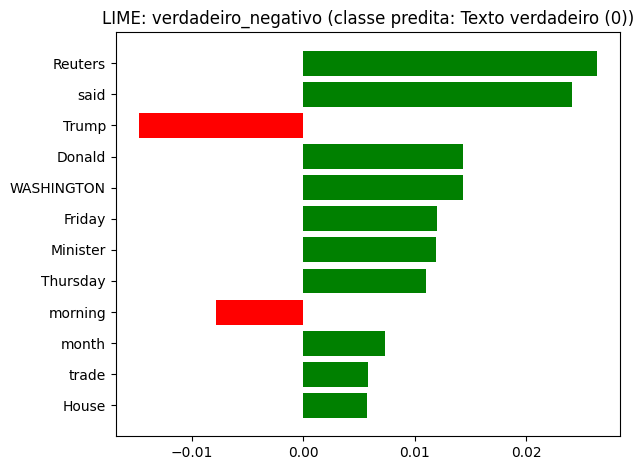

EXEMPLO: verdadeiro_positivo
y_true=1 | y_pred=1 | proba_fake=0.9999
Trecho:  Trump: Obama Just Looks Anti-Cop (VIDEO) After the horrific murder of three police officers in Baton Rouge, Louisiana, President Obama gave a heartfelt speech   one that could have been given by any politician   condemning the  cowardly and reprehensible attack  against those who  put their lives on the line for ours every day.  Obama declared that  justice will be done. That, though, wasn t conv ...

Top termos (termo, peso) para a classe predita:
  image                     +0.0026
  Obama                     +0.0025
  video                     +0.0022
  VIDEO                     +0.0019
  Featured                  +0.0018
  Getty                     +0.0017
  read                      +0.0017
  Fox                       +0.0016
  black                     +0.0016
  just                      +0.0015
  African                   -0.0014
  Images                    +0.0013


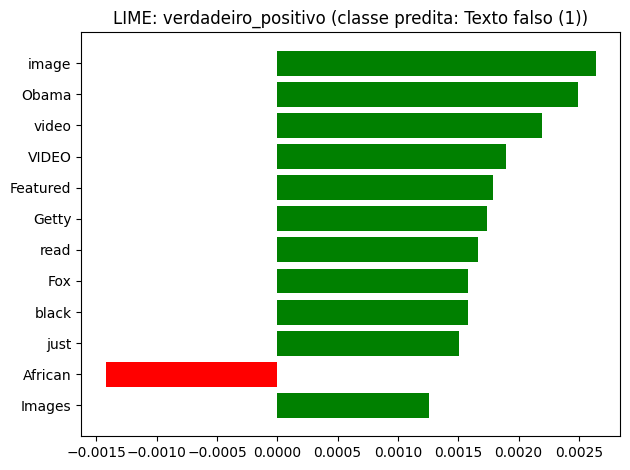

EXEMPLO: falso_positivo
y_true=0 | y_pred=1 | proba_fake=0.8892
Trecho: Transcript of Trump video statement in response to lewd remarks about women WASHINGTON (Reuters) - U.S. Republican presidential nominee Donald Trump issued a video statement early on Saturday in response to the disclosure of a 2005 videotape of him making lewd remarks about women. Here is a text of his statement: “I’ve never said I’m a perfect person, nor pretended to be someone that I’m not. I’ve ...

Top termos (termo, peso) para a classe predita:
  video                     +0.2323
  Reuters                   -0.0980
  Hillary                   +0.0822
  said                      -0.0819
  Republican                -0.0634
  today                     +0.0539
  WASHINGTON                -0.0535
  America                   +0.0523
  ve                        +0.0490
  just                      +0.0465
  presidential              -0.0403
  statement                 -0.0243


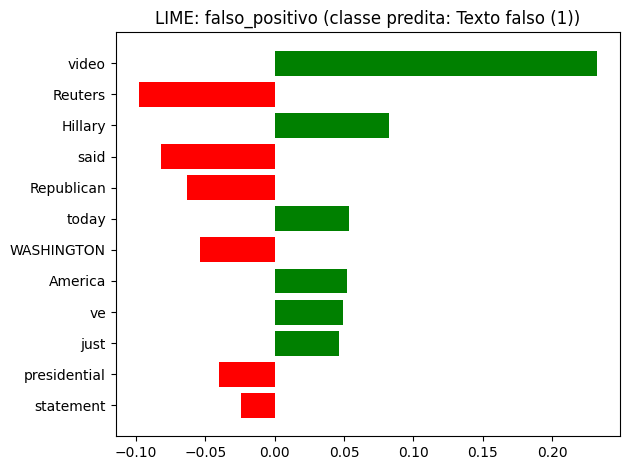

EXEMPLO: falso_negativo
y_true=1 | y_pred=0 | proba_fake=0.0587
Trecho: BREAKING: NORTH KOREA Detains American Student For “Hostile Act” Apparently it takes just one American student to destroy the unity in North Korea:North Korea has detained a U.S. university student, the third western citizen known to be held in the isolated state, for committing a  hostile act  and wanting to  destroy the country s unity , it said on Friday.and was detained at Pyongyang airport on ...

Top termos (termo, peso) para a classe predita:
  said                      +0.1077
  Reuters                   +0.1019
  BREAKING                  -0.0424
  China                     +0.0330
  just                      -0.0319
  American                  -0.0310
  destroy                   -0.0291
  Friday                    +0.0288
  Korea                     +0.0280
  Washington                +0.0276
  North                     +0.0260
  agency                    +0.0245


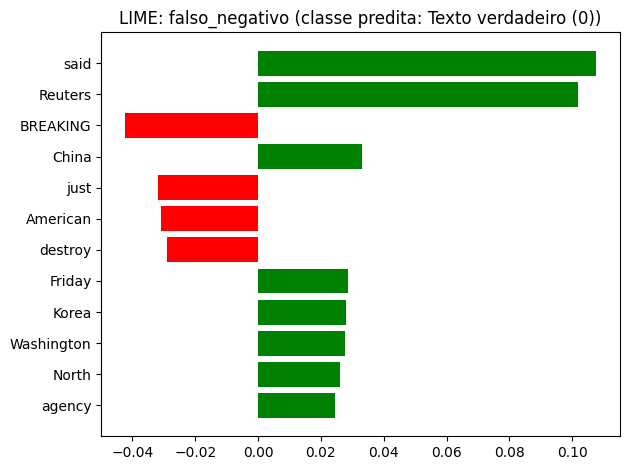

In [5]:
NUM_FEATURES = 12  # quantos termos mostrar
TOP_LABELS = 1       # explicar apenas a classe predita

lime_outputs = []

for name, row in examples.items():
    text = row["text"]
    y_true = int(row["y_true"])
    y_pred = int(row["y_pred"])
    proba_fake = float(row["proba_fake"])

    print("="*80)
    print(f"EXEMPLO: {name}")
    print(f"y_true={y_true} | y_pred={y_pred} | proba_fake={proba_fake:.4f}")
    print("Trecho:", str(text)[:400].replace("\n"," ") + " ...")

    exp = explainer.explain_instance(
        text_instance=text,
        classifier_fn=predict_proba_for_lime,
        num_features=NUM_FEATURES,
        top_labels=TOP_LABELS
    )

    label_to_show = y_pred  # explica a classe predita
    weights = exp.as_list(label=label_to_show)
    lime_outputs.append((name, exp, weights))

    print("\nTop termos (termo, peso) para a classe predita:")
    for term, w in weights:
        print(f"  {term:25s} {w:+.4f}")

    fig = exp.as_pyplot_figure(label=label_to_show)
    plt.title(f"LIME: {name} (classe predita: {class_names[label_to_show]})")
    plt.tight_layout()
    plt.show()


# Conclusão

A análise de interpretabilidade com LIME demonstra que o modelo baseline utiliza evidências linguísticas semanticamente plausíveis para a tomada de decisão. Termos associados ao estilo jornalístico institucional (ex.: Reuters, said, referências governamentais) contribuíram para a classe de notícias verdadeiras, enquanto palavras frequentemente presentes em conteúdos sensacionalistas ou opinativos (ex.: video, watch) influenciaram a classe de notícias falsas.

Os erros observados ocorreram principalmente em textos com características híbridas entre jornalismo formal e conteúdo opinativo, evidenciando limitações inerentes a representações baseadas apenas em frequência de termos. Ainda assim, os resultados confirmam a coerência do comportamento do modelo, fornecendo transparência sobre os fatores que influenciam as predições.

Esses resultados forneceram evidências sobre os padrões linguísticos explorados pelo modelo e suas limitações, motivando a adoção de uma abordagem mais robusta nas etapas posteriores.